# Example 3a: Hybrid transfer learning for image classification (CIFAR)

This is an example of a hybrid network for image classification, developed according to the *classical-to-quantum transfer learning* scheme presented in [1]. 

This notebook is inspired by the official PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy [2].

The starting point is a state-of-the-art convolutional neural network (ResNet18) that has been pre-trained on the public ImageNet dataset. We replace the last fully connected layer with a *dressed quantum circuit* that we train on a different dataset. Specifically, we focus on two classes of the CIFAR 10 dataset: *dogs* and *cats*. The code can be easily changed to deal with different and/or more CIFAR classes.

## General setup
**Important:** this code makes use of the machine learning framework *PyTorch*, which is assumed to be correctly installed.

The main imported modules are: some common PyTorch libraries, the quantum 
software framework `pennylane` [3] and the python plotting library `matplotlib`.

In [1]:
# openMP: number of parallel threads.
%env OMP_NUM_THREADS=1
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
# Pennylane
import pennylane as qml
from pennylane import numpy as np
# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


Setting of the main parameters of the network model and of the training process.<br>
**Remark:** To reproduce the results of [the paper], `num_epochs` should be set to ... which may take many hours. We suggest to first try with `num_epochs=1`, just to check that everything runs smoothly.

In [2]:
filtered_classes = ['cat', 'dog']  # subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # number of qubits
quantum = True                     # If set to "False", the dressed quantum circuit is replaced by 
                                   # an enterily classical net (defined by the next parameter). 
classical_model = '512_n'          # possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # learning rate
batch_size = 8                     # number of samples for each training step
num_epochs = 3                     # number of training epochs
q_depth = 5                        # depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # learning rate reduction applied every 10 epochs.                       
n_quantum_layers = 15              # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # seed for random number generator
start_time = time.time()           # start of the computation timer

Let us initialize a PennyLane device to a ProjectQ quantum simulator. If missing, the ProjectQ plugin can be installed by running: `python -m pip install pennylane_pq`.

In [3]:
dev = qml.device('projectq.simulator', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset loading

**Remark:** It may take some time to download the CIFAR dataset (only the first time).
The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


################ LOAD CIFAR dataset #########################################
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}
# all CIFAR classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get indices of samples associated to filtered_classes
filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train':[], 'val':[]}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
# initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
#################### END CIFAR dataset loading ###################################

# number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


Let us show a mini-batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

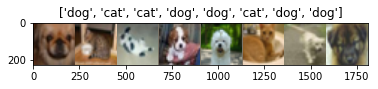

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [7]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1,nqubits - 1, 2):  #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Let us define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding);
2. Successively a sequence of trainable rotation layers and constant entangling layers is applied. This block is responsible for the main computation necessary to solve the classification problem.
3. Eventually, for each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [9]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        # reshape weights
        q_weights = q_weights_flat.reshape(n_quantum_layers, n_qubits)
        H_layer(n_qubits)   # Start from state |+> , unbiased w.r.t. |0> and |1>
        RY_layer(q_in)      # Embed features in the quantum node
       
        # sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])
            
        # expectation values in the Z basis
        exp_vals = [qml.expval.PauliZ(position) for position in range(n_qubits)]
        return tuple(exp_vals)

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.<br>
This is a concatenation of:
1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
2. The previously defined quantum circuit (`q_net`)
2. A classical post-processing layer (`nn.Linear`)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with *n* real outputs (one for each class of images).

In [ ]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta*torch.randn(n_quantum_layers*n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = F.tanh(pre_out) * np.pi / 2.0   
            # apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem, self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:
1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.<br> **Important:** the model is downloaded from Internet and it may take a long time (only the first time). 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (`Quantumnet`). Alternatively, if `quantum==False`, an entirely classical analogue is used.

In [11]:
model_hybrid = torchvision.models.resnet18(pretrained=True)
for param in model_hybrid.parameters():
    param.requires_grad = False
if quantum:
    model_hybrid.fc = Quantumnet()
elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512, len(filtered_classes))
elif classical_model == '512_nq_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, len(filtered_classes))) 
elif classical_model == '551_512_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, len(filtered_classes)))
# use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [12]:
criterion = nn.CrossEntropyLoss()

We also initialize the *optimizer* which is called at each training step in order to update the weights of the model.

In [13]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every epoch.

In [14]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=1, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications). 

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    # track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # batch loss
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                # check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss,best_acc))
        return model

We are ready perform the actual training process.

In [16]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/3 Loss: 0.5538 Acc: 0.7223        783
Phase: val   Epoch: 1/3 Loss: 0.4698 Acc: 0.7560        
Phase: train Epoch: 2/3 Loss: 0.4800 Acc: 0.7769        835
Phase: val   Epoch: 2/3 Loss: 0.4098 Acc: 0.8270        
Phase: train Epoch: 3/3 Loss: 0.4722 Acc: 0.7751        045
Phase: val   Epoch: 3/3 Loss: 0.4039 Acc: 0.8165        
Training completed in 640m 38s
Best test loss: 0.4039 | Best test accuracy: 0.8270


We save the optimal weights that achieved the best accuracy into a PyTorch file that will be created in the current working directory. In this way, the saved weights can be loaded in the future without training again.

**Important: Be aware that running next cell will overwrite a previously saved file. So, we suggest to run the next cell only after a good training process.**

In [17]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_dogs_cats.pt")
else:
        torch.save(model_hybrid.state_dict(), "classical_dogs_cats.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file
To load the pre-trained weights it is necessary to first define the model. So, before this cell, one should have run all the cells above the *[Training and results](##Training_and_results)* section.

In [18]:
if quantum:
    model_hybrid.load_state_dict(torch.load("quantum_dogs_cats.pt"))
else:
    model_hybrid.load_state_dict(torch.load("classical_dogs_cats.pt"))

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [19]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches=dataset_sizes['val']//batch_size
it=0
model_hybrid.eval()
for inputs, cifar_labels in dataloaders['val']:
                    inputs = inputs.to(device)
                    labels=torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    batch_size_=len(inputs)
                    with torch.set_grad_enabled(False):
                        outputs = model_hybrid(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    running_loss += loss.item() * batch_size_
                    batch_corrects=torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
                    it+=1
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects/ dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 250/251
Test Loss: 0.4098 Test Acc: 0.8270        


## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

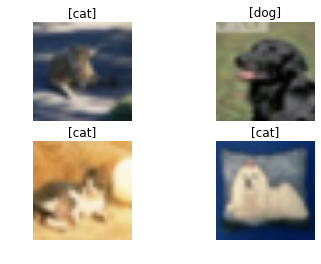

In [26]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=4)

## References

[1] Author1, Author2, ... _Transfer learning in hybrid classical-quantum neural networks_, [arXiv:xxxx.xxxx](https://arxiv.org/abs/xxxx.xxxx), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).